# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [2]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**

- 在仿真过程中，有udacity logo的智能车是不会移动的；
- 随着红绿灯的变化，智能车收到的reward情况是连续若干次正数奖励和连续若干次负数奖励交替出现；
- 当为红灯时，不移动的智能车处于"Agent idled at a red light."的状态，这个状态下智能车会收到正奖励；当为绿灯时，智能车可能处于两种状态，一种为"Agent idled at a green light with oncoming traffic"，这个状态下智能车会收到正奖励，另一种为"Agent idledd at a green light with no oncoming traffic"，这个状态下智能车会收到负奖励。

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

- agents.py Python文件中，三个可以修改的标记值为 learning, epsilon, alpha。当learning为True，agent会具有学习能力，当learning为False，agent不具备学习能力。epsilon为随机探索概率，在每一次探索之前选择策略的时候，有epsilon的概率为随机选择一个策略，有1-epsilon的概率为选择当前的最优策略。alpha为学习步长，当需要更新Q-value的时候，未来新获得的信息所占的权重为alpha，旧Q-value所占的权重为(1-alpha)；

- agent.py 的 updata 方法中，有两行代码：
        action = self.choose_action(state)  # Choose an action
        reward = self.env.act(self, action) # Receive a reward
  很明显，当agent执行一个动作时，调用了 environment.py 中 Environment class 的 act 方法。
  
- simulator.py Python文件中，render_text()是模拟过程的non-GUI显示，相关的信息会显示在terminal中；render()则是完成模拟过程的GUI显示。
     
- planner.py Python文件 next_waypoint()方法中，逻辑判断 elif dx != 0 及相关代码块在 elif dy != 0及相关代码块之前，该方法先考虑 East-West 方向。

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'Left'` (turn left), `'Right'` (turn right), or `'Forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


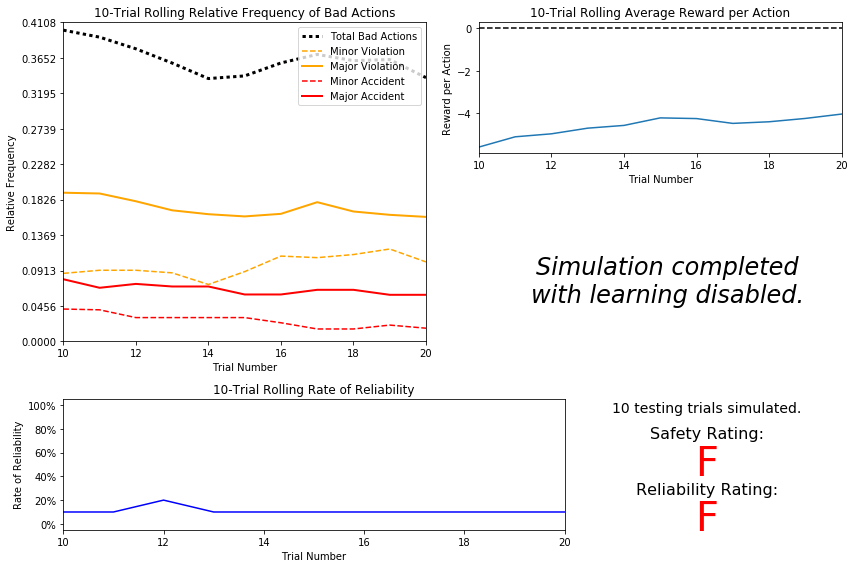

In [4]:
# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliabilty make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**
-  agent做出错误决定的概率在（0.33，0.41）之间，平均值为0.365。agent发生事故的概率Pr(Accident) = Pr(Major Accident)+Pr(Minor Accident)，Pr(Major Accident)在（0.065，0.09）之间，Pr(Minor Accident)在（0.02，0.045）之间，Pr(Accident)在（0.085，0.135）之间，平均值为0.11，错误决定造成事故的频率为Pr(Accident)/Pr(Bad decision)＝0.3，理解为每10次bad decisions中平均会造成3次事故。

- Reliability Rating 是 F，60%以上的实验，agent未抵达目的地。当agent是随机选择方向运动的时候，agent抵达目的地的概率肯定是很低的，符合Reliability Rating的打分。

- agent收到的奖励都是负奖励，即惩罚，范围在（－6，－4）之间。参照可视化中的图像，agent收到的平均惩罚还是很大的。

- 随着试验次数的增加，agent的safety和reliability并没有较大的变化，一直处于很差的水平。

- 对于乘客来说，这辆智能车既不安全也不可靠。综合以上的分析和可视化中的结果，agent做出错误决定的比例高达36.5%，其中bad decisions中造成事故的概率高达30%，断定它为不安全的。agent选择的行为平均收到(-6,-4)范围的惩罚，并且达到率在 (10%,20%)的范围里，断定它为不可靠的。可视化的结果中最后也给出了该智能车的分数，安全和可靠系数均为最差的F。

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate?*

**Answer:**

- 对学习safety和efficiency帮助都很大的特征是'light'。'light'为红色的时候，智能车是不能行驶的，所以这个特征一定程度上帮助智能车提高安全性；'light'为绿色的时候，智能车可以选择一个方向行驶，提高了智能车移动的频率，一定程度上帮助智能车提高效率。

- 在智能车当前方向的基础上，'waypoint'提供了距离目标最近的点所在的方向，对学习efficiency有很大的帮助；'light'如上所述，对学习safety和efficiency都有帮助；'left'，'right'和'oncoming'提供了智能车左，右和相同路线上是否有车的信息，如果有则提供该车移动方向的信息，对避免事故即学习safety有很大的帮助。

- 在environment.py代码129-130行，每一次测试开始的时候，会计算start至destination的距离，deadline = 5 * distance，deadline的取值范围较大。如果将'deadline'作为state的一个特征，会造成state的空间过大，智能车很难完成对每个state的最优策略的学习。

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the evironment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

- 根据问题4，选择的特征有'waypoint','light','left','right','oncoming'。特征'waypoint','left','right','oncoming'都有'None','forward','left','right'四个值，特征'light'有 True,False 两个值。通过观察planner.py的代码，特征'waypoint'只有在到达目的地时，才会返回None，即在智能车运行过程中'waypoint'只会返回('left','right','oncoming')三种返回值。所以 state size = 3 x 2 x 4 x 4 x 4 = 384。

- 观察GUI中的环境和代码，可以发现：智能车与目标之间最近点所在的方向，即特征'waypoint'，在不同的情况下可以分别取到它的四个值；模拟出的交通环境有可以行驶的绿灯和不准行驶的红灯，特征'light'也可以在不同的情况下分别取到它的两个值；除了智能车，还模拟了很多dummy agent，通过与智能车相对位置的组合，特征'left','right','oncoming'也可以在不同的情况下取到每一个值。所以通过一定量的训练，智能车可以学习到对应每一个状态下的最优策略。

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the interative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.01). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

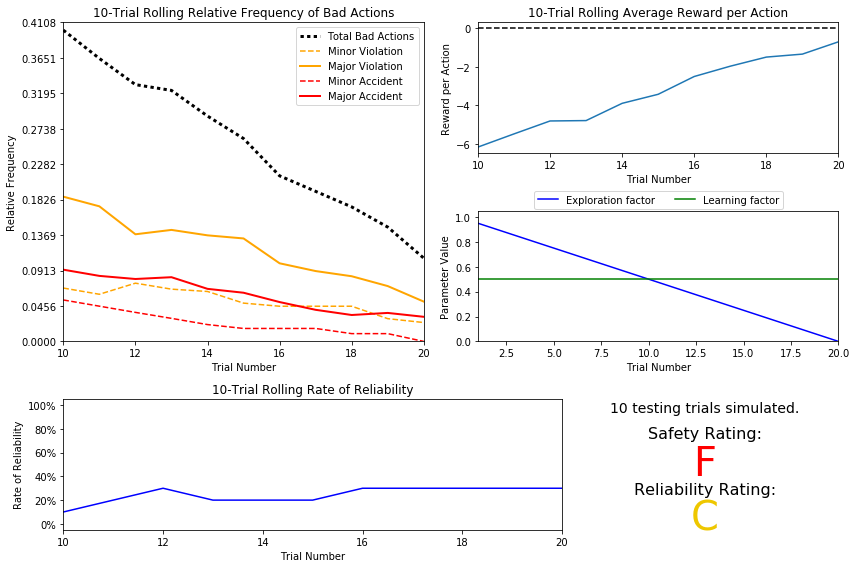

In [3]:
# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

- 普通车和简版Q-learning车的结果的相似点：Major Accident 和 Minor Accident 仍然有较大的频率，与普通车的这两项数据的大小差不多；10次测试结果的安全系数都是最低的F。

- 训练次数大概需要18-20次，Rate of Reliability趋于稳定，证明该智能车在测试之前应该训练18-20次。epsilon每次训练后会减少0.05，18-20次训练后epsilon的取值范围为（0，0.1），说明对任意一个已学习过的状态，智能车随机选择操作的概率非常低，选择已知最优操作的概率很高，此时智能车的reliability分数相比较少训练次数的时候提高了很多并趋于一个稳定的状态，符合强化学习的原理。

- 是的，第三个图精确地反应了epsilon随着训练次数的变化。epsilon的初始值为1，并且随着训练次数以0.05线性减小，在第20次训练时减少为0，符合代码的预期。

- 第一张图很清楚地显示，随着训练次数的增加，total bad actions 的数目在不断减少；第二张图很清楚地显示，虽然平均奖励值仍然为负数，但是随着训练次数的增加，平均奖励值在不断提高。

- 普通车和简版Q-learning车的安全分数是一样的，最低的F；简版Q-learning车的reliability分数提高到了C级别，至少70%的情况下在规定时间内抵达目的地，相比普通车的reliability分数的F级别，有了较大的提升。

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the impliciations it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

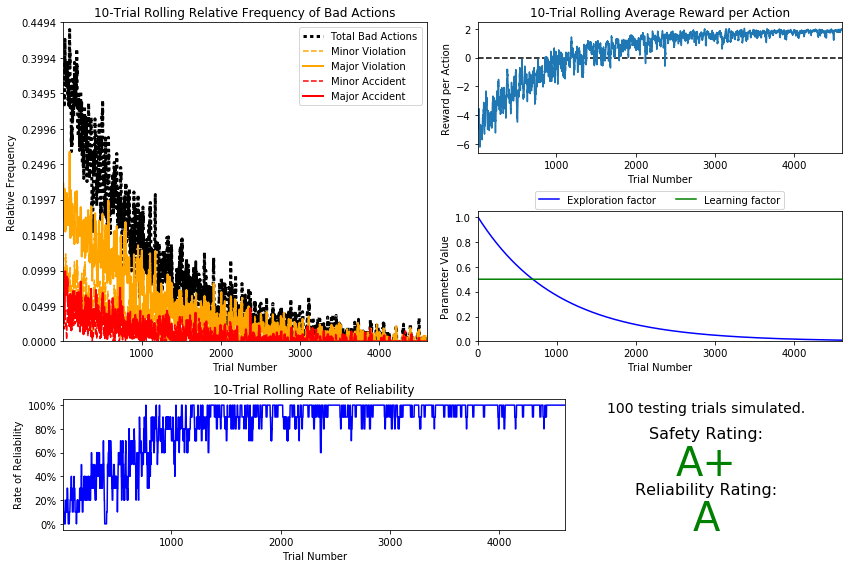

In [8]:
# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

回答细分问题之前，我先陈述下对智能车学习有帮助的参数的调节，相关的参数有：探索因子epsilon、学习步长alpha、epsilon衰减函数、epsilon衰减函数里的参数、忍受因子tolerance。在 Question 2 中已经介绍了epsilon的取值范围和意义，我选择了保留默认值epsilon=1.0，让智能车在开始学习的阶段多选择随机探索，对任一state的每种策略都能尝试和学习。学习步长alpha，合理的取值范围(0.0, 1.0)，在Q-value更新的时候，有alpha权重的值来自于新的学习奖励，有(1-alpha)权重的值来自于已有的经验，我选择了默认值alpha=0.5，理由在下面的细分回答中有解释。epsilon衰减函数，项目中提供了四种衰减函数，首先排除了第二个epsilon = 1/t^2，虽然epsilon是随着试验次数减小的，但是没有其余参数调节该函数的衰减速度；然后排除第四个epsilon = cos(at)，在智能车学习的过程中，前期应该有较多的探索后期可以多使用学习到的最优策略，cos(at)使epsilon的值周期变化，并不合适；第一个和第三个衰减函数都适合于该项目中的智能车，第一个指数型衰减函数epsilon = a^t，为了使智能车在前期有尽可能多种方式的尝试，应该使函数的衰减速度较慢，所以a的值应该偏向于1.0，我选择了0.999；第三个指数型衰减函数epsilon = exp(-at)，同样的原因应该使函数的衰减速度较慢，对于该函数，a的值应该偏向于0.0。忍受因子tolerance，epsilon衰减到比tolerance小的时候，智能车的训练就会停止，所以tolerance在合理的范围内应该尽量小，使智能车有足够的训练量学习到各种状态，然而也不能过于小这样会浪费时间，我选择tolerance = 0.01。观察上面的可视化结果，通过探索因子、探索因子衰减函数、衰减函数的参数、tolerance因子的组合，各项指标的变化随着足够的训练量（3000－4000次）已渐趋于稳定，之后的训练验证了该趋势，既保证了训练量也没有过度训练浪费资源。

- 我选择了第一个指数型衰减函数，且a=0.999。

- 观察可视化的结果，大概训练到3000次的时候，第一张图里的total bad actions、minor violation、major violation、minor accident、major accident的频率都下降到了很低的标准并且之后的变化不大；第二张图里的平均奖励值从－6上升到了1.7，之后趋于平稳略有增加；第三张图里的可靠分数保持在80%至100%的范围内浮动，之后变化不大。

- epsilon-tolerance的取值为0.01，因为tolerance的取值很小，epsilon衰减到tolerance所需要的训练次数就会增多，保证了模型通过足够的训练量尽可能学到每一个state对应的最优策略；学习因子alpha取值为0.5，智能车Q-value的更新有50%来自新尝试后的奖励，有50%来自于过去的经验。由于该项目的alpha是固定值，alpha取0.5，可以平衡不同阶段更新Q-value时的需求。具体地说，在学习开始阶段阶段，智能车能以一个较快的速度学习到正确的策略；之后随着经验的积累，智能车会保留一半的已有经验。

- Q-learner与之前的default Q-learner相比，有了非常大的进步。首先是通过控制探索系数，训练量从20次增加到了4000次，使模型学习的更加充分。再来看结果，第一张图里反映的total bad actions、minor violation、major violation、minor accident、major accident的频率，都下降到了很低的标准接近于0，然而default Q-learning的这几个指标处于较高的值；第二张图反应的平均奖励值，default Q-learning虽然也在一直上升但最终仍为负数，Q-learning是一直上升并最终稳定在一个正奖励（＋2）；第四张图里反映的可靠分数，default Q-learning最终只有25%左右的成绩，而Q-learning在训练3000次以后保持在80%至100%的范围内浮动；最后的结果，default Q-learning的安全分数是F，可靠分数是C，而Q-learning的安全分数是A+，可靠分数是A，直接反应出了巨大的进步。

- 通过最后的结果可以看出，Q-learning agent通过足够的训练量，在绝大多数的状态下都学到了合适的策略；最后的结果是agent是100%安全，90%的路线都可以按时抵达，我觉得这个结果是可以的，当然可以通过更多的参数调试工作争取将可靠分数也达到A+级别。

### Review

不过，有一些理解偏差是需要为你指明的。
题干中给出的四个函数都是减函数，都是正确可用的。并不如你所描述的它们不能作为衰减函数来使用。

"首先排除了第二个epsilon = 1/t^2，虽然epsilon是随着试验次数减小的，但是没有其余参数调节该函数的衰减速度"
反驳：你可以为它添加参数，比如乘以一个固定的常数，形如 a / b*t^2 + c

"然后排除第四个epsilon = cos(at)，在智能车学习的过程中，前期应该有较多的探索后期可以多使用学习到的最优策略，cos(at)使epsilon的值周期变化，并不合适"
反驳：这里我们会使用一个小常数a来限制函数的范围，使得它不会进入下一个周期
比如，当a = π / 2000时

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8
Provide a few examples (using the states you've defined) of what an optimal policy for this problem would look like. Afterwards, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ Provide an example of a state and all state-action rewards recorded, and explain why it is the correct policy.

**Answer:** 

- 对于该项目中的智能车，某一状态下的最佳策略表示：当智能车处于某一状态时，选择并执行最佳策略，在保证不出事故、不违反规则的前提下，尽可能快地靠近目的地。

- 智能车有可能学不到所有state下的最优策略，造成这个的原因可能有很多。比如，智能车在学习阶段的前期几乎没有进入到某一state，当后期再进入到该state的时候，此时探索因子epsilon较小，智能车很大概率上会选择已有的经验而不是随机探索，所以智能车很有可能并没有尝试过该state下的随机策略。再比如，environment.py 286行代码，reward初始化是[-1,1]，再通过后面的判断修改reward，如果两个策略本应该对应的Q-value差距不大，可能会因为初始化的随机性造成sub-optimal策略的Q-value高于最优策略，造成的结果是智能车学习到了sub-optimal策略。

- sim_improved-learning.txt中最优策略的例子，59-63行：
  ('right', 'green', None, 'forward', 'left')
     - forward : 1.46
     - None : 0.49
     - right : 1.95
     - left : 0.60
  
  对于这一state，Q-value最大的策略是'right'，这就是智能车在该状态下学到的最优策略。通过后四个状态state['light']='green',state['left']=None,state['right']='forward',state['oncoming']='left'，当智能车执行'right'策略时，不会造成违规和事故；再就是看state['waypoint']='right'，下一步中距离目的地最近的点在当前位置的右方。所以智能车在该状态下学到了最优策略'right'。

- sim_improved-learning.txt中也有没学到最优策略的例子，275-279行：
  ('right', 'green', 'left', 'right', 'forward')
     - forward : 1.24
     - None : 0.00
     - right : 0.00
     - left : -17.10
   
  state['waypoint'] = 'right'，表示下一步中距离目的地最近的点在当前位置的右方。再看后面四个状态，state['green']表示可行驶，state['left']='left'左边的车要左转，state['right']='right'右边的车要右转，state['oncoming']='forward'相对的车要前行，所以智能车选择'right'策略的时候是不会造成违规和事故的，所以该状态下智能车的最优策略应该是'right'。再看学习结果，Q-value最高的是'forward'而不是'right'，所以智能车在该状态下没有学到最优策略。

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propogating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:** 

- 从智能车的角度，刚才讨论最优策略的时候有谈到，智能车选择一个策略的标准首先应该是保证安全级别，避免事故和违规。假设考虑了下一个状态的Q-value，r(a) + gamma * max Q(s',a')，因为 Q(s',a') 的介入可能会影响智能车学习到最优策略。比如说，通过源码可以看到 minor violation 的奖励是－5，但如果执行该策略后的状态的Q(s',a')很高，r(a) + gamma * max Q(s',a') 的组合可能就会是个较大的正奖励，这就会导致智能车将这个会造成 minor violation 的策略学习成最优策略，违背了智能车应该遵守的初衷。

- 从环境的角度，通过源码可以知道该项目的原理，智能车需要经过很多次训练，每一次训练的环境都是随机生成的。每一次的训练环境，不仅仅是出发地和目的地很有可能会不同，从出发地到目的地的最优路线更是很难重复。这样会造成对某一state，它执行同一个策略a，每一次训练时抵达的下一个状态 state' 极大可能是不同的。比如说，这次训练T(s,a)会抵达s1，下一次训练T(s,a)可能就会抵达s2。很显然，对某一特定的待学习状态，通过不固定甚至说是变化莫测的未来状态，反馈给当前这个固定的状态的Q(s,a)，肯定是不合理的。

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.